In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
# sys.path.append('/Users/Josh/Documents/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation, training_classHead

## Import training data

In [4]:
# import pickle

# with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
#     statFiles_scraped = pickle.load(file)

In [5]:
# keys_toDelete = [
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
# ]
# for key in keys_toDelete:
#     del statFiles_scraped[key]

In [6]:
# sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

# images_all = np.concatenate(sf_list, axis=0)

# images_all.shape

In [7]:
# images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [8]:
# # create validation set
# # X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
# X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
# (X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

<IPython.core.display.Javascript object>


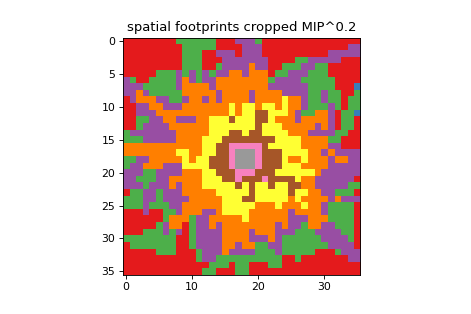

<IPython.core.display.Javascript object>


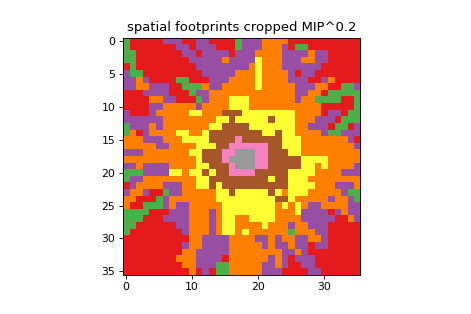

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>


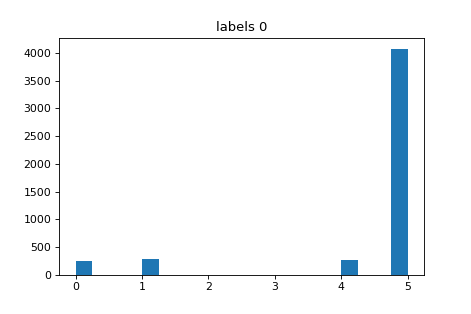

<IPython.core.display.Javascript object>


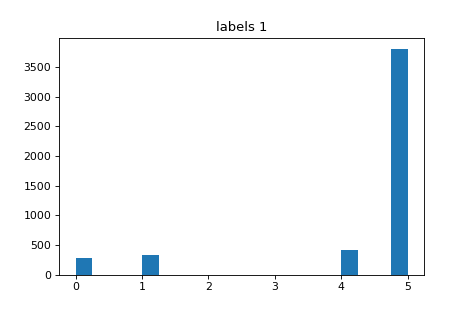

In [65]:
dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

In [66]:
# tmpd = pd.DataFrame(labels)
# tmpd[1] = tmpd[0]
# tmpd.groupby(0).count()

In [67]:
#code doesn't work with multiple open number maybe (?)

In [68]:
def squeeze_integers(arr):
    """
    Make integers in an array consecutive numbers
     starting from 0. ie. [7,2,7,4,1] -> [3,2,3,1,0].
    Useful for removing unused class IDs from y_true
     and outputting something appropriate for softmax.
    RH 2021
    Args:
        arr (np.ndarray):
            array of integers.
    
    Returns:
        arr_squeezed (np.ndarray):
            array of integers with consecutive numbers
    """
    uniques = np.unique(arr)
    arr_squeezed = copy.deepcopy(arr)
    for val in np.arange(0, np.max(arr)+1):
        if np.isin(val, uniques):
            continue
        else:
            arr_squeezed[arr_squeezed>val] = arr_squeezed[arr_squeezed>val]-1
    return arr_squeezed

In [69]:
labels = squeeze_integers(labels)
images_labeled = images_labeled[labels != 2]
labels = labels[labels != 2]
labels = squeeze_integers(labels)

## Balance classes of inputs

In [15]:
duplicates = 1

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 36, 36)
(9714,)
532
532
620
0
0
(9714, 36, 36)
(9714,)


In [16]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_dup[:], labels_dup[:], test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((8256, 36, 36), (8256,)), ((1458, 36, 36), (1458,)))

<IPython.core.display.Javascript object>


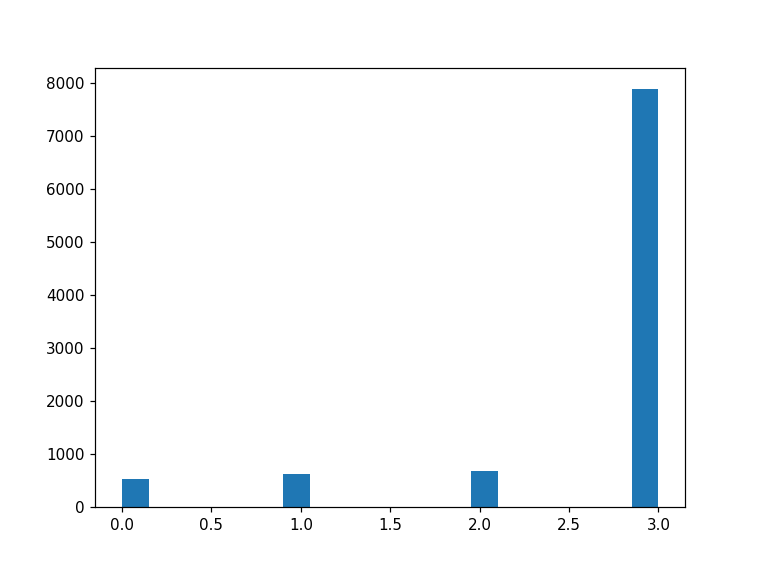

In [17]:
plt.figure()
plt.hist(labels_dup, 20);

## Define augmentation pipeline

In [83]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
    torchvision.transforms.GaussianBlur(kernel_size=5,
                                        sigma=(0.0001, 0.5)),
    
    torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
                                             p=0.5, 
                                             interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                             fill=0),
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.3, 0.3),
                                        scale=(0.7, 1.7), 
                                        shear=(-30, 30, -30, 30), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    
    augmentation.AddPoissonNoise(   level_bounds=(0,0.7),
                                    prob=1),

    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.4,
                                    prob=1),
)
# scripted_transforms = torch.jit.script(transforms)
scripted_transforms = transforms



dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
                                    y_train, 
                                    n_transforms=2, 
#                                     class_weights=[1]*3,
                                    class_weights=[0.34, 0.33, 0.33, 0.00],
#                                     class_weights=[0.0, 0.0, 0.0, 1.00],
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=2048,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=False,
#                                                 num_workers=32,
#                                                 num_workers=0,
                                                num_workers=32,
#                                                 prefetch_factor=0,
                                                persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )         

0.0024993419647216797
0.024519681930541992
0.023876428604125977
0.02457427978515625


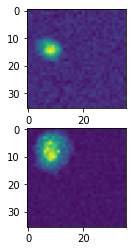

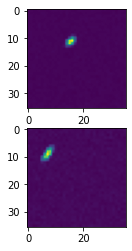

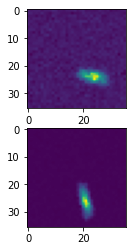

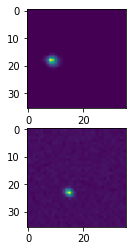

In [84]:
import time

%matplotlib inline
tic=time.time()
for ii, im in enumerate(dataset_train):
#     for jj in range(im[0])
    print(time.time() - tic)
    tic = time.time()
#     print((im[0][0]).shape)
#     print(im[3])
    fig, axs = plt.subplots(len(im[0]))
    for jj, ax in enumerate(axs):
        ax.imshow(im[0][jj].cpu().squeeze())
    if ii > 2:
        break

## Train

In [85]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [86]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=16)
model.train()
# criterion = CrossEntropyLoss()
criterion = CrossEntropyLoss(reduction='none')

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0005,
#                                                    gamma=1,
                                                  )
val_obj = training_simCLR.validation_Obj(   X_val,
                                            y_val,
                                            model,
                                            criterion,
                                            DEVICE=DEVICE,
                                            dtype_X=torch.float32,
                                            dtype_y=torch.int64) # Needs to take in weights

model.to(DEVICE)
criterion = criterion.to(DEVICE)

# classHead = HeadModel(model, RandomForestClassifier)
classHead = training_classHead.HeadModel(model, LogisticRegression)
dataset_train.headmodel = classHead
# dataset_train.headmodel = None

losses_train, losses_val, val_accs = [], [np.nan], []

In [87]:
%matplotlib inline

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
                                validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=100,
                               )
    # model predict
    # Update model in DS
    # get item calls model for each sample
    # output
    # X sample weights predictions
    
#     classHead.fit(X_train[:, None, :, :], y_train, solver='liblinear')
    
#     proba = classHead.predict_proba(X_train[:, None, :, :])
#     class_weights = proba.sum(axis=0)
#     total_num = class_weights.sum()
    
#     eps = 1e-4
    
#     class_weights[class_weights <= 3] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()
#     final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])
    
#     print(class_weights)

#     dataset_train.set_classweights(final_weights)
    
#     print('dataset_train.final_weights', dataset_train.class_weights)


epoch: 0
Iter: 0/4, loss_train: 8.192, loss_val: nan, lr: 0.0009995
epoch: 1
Iter: 0/4, loss_train: 7.1129, loss_val: nan, lr: 0.0009975
epoch: 2
Iter: 0/4, loss_train: 6.961, loss_val: nan, lr: 0.00099551
epoch: 3
Iter: 0/4, loss_train: 6.9634, loss_val: nan, lr: 0.00099352
epoch: 4
Iter: 0/4, loss_train: 6.8933, loss_val: nan, lr: 0.00099153
epoch: 5
Iter: 0/4, loss_train: 6.8583, loss_val: nan, lr: 0.00098955
epoch: 6
Iter: 0/4, loss_train: 6.8446, loss_val: nan, lr: 0.00098757
epoch: 7
Iter: 0/4, loss_train: 6.7741, loss_val: nan, lr: 0.0009856
epoch: 8
Iter: 0/4, loss_train: 6.8056, loss_val: nan, lr: 0.00098363
epoch: 9
Iter: 0/4, loss_train: 6.6843, loss_val: nan, lr: 0.00098167
epoch: 10
Iter: 0/4, loss_train: 6.6664, loss_val: nan, lr: 0.0009797
epoch: 11
Iter: 0/4, loss_train: 6.7313, loss_val: nan, lr: 0.00097775
epoch: 12
Iter: 0/4, loss_train: 6.6756, loss_val: nan, lr: 0.00097579
epoch: 13
Iter: 0/4, loss_train: 6.6231, loss_val: nan, lr: 0.00097384
epoch: 14
Iter: 0/4, l

Iter: 0/4, loss_train: 6.4695, loss_val: nan, lr: 0.0007925
epoch: 117
Iter: 0/4, loss_train: 6.4649, loss_val: nan, lr: 0.00079092
epoch: 118
Iter: 0/4, loss_train: 6.4154, loss_val: nan, lr: 0.00078934
epoch: 119
Iter: 0/4, loss_train: 6.4995, loss_val: nan, lr: 0.00078776
epoch: 120
Iter: 0/4, loss_train: 6.4419, loss_val: nan, lr: 0.00078619
epoch: 121
Iter: 0/4, loss_train: 6.4863, loss_val: nan, lr: 0.00078462
epoch: 122
Iter: 0/4, loss_train: 6.4493, loss_val: nan, lr: 0.00078305
epoch: 123
Iter: 0/4, loss_train: 6.4721, loss_val: nan, lr: 0.00078148
epoch: 124
Iter: 0/4, loss_train: 6.4376, loss_val: nan, lr: 0.00077992
epoch: 125
Iter: 0/4, loss_train: 6.4146, loss_val: nan, lr: 0.00077836
epoch: 126
Iter: 0/4, loss_train: 6.4562, loss_val: nan, lr: 0.00077681
epoch: 127
Iter: 0/4, loss_train: 6.4464, loss_val: nan, lr: 0.00077525
epoch: 128
Iter: 0/4, loss_train: 6.4823, loss_val: nan, lr: 0.00077371
epoch: 129
Iter: 0/4, loss_train: 6.4134, loss_val: nan, lr: 0.00077216
epoc

epoch: 231
Iter: 0/4, loss_train: 6.4224, loss_val: nan, lr: 0.00062963
epoch: 232
Iter: 0/4, loss_train: 6.4298, loss_val: nan, lr: 0.00062838
epoch: 233
Iter: 0/4, loss_train: 6.4555, loss_val: nan, lr: 0.00062712
epoch: 234
Iter: 0/4, loss_train: 6.4818, loss_val: nan, lr: 0.00062587
epoch: 235
Iter: 0/4, loss_train: 6.4365, loss_val: nan, lr: 0.00062462
epoch: 236
Iter: 0/4, loss_train: 6.4285, loss_val: nan, lr: 0.00062337
epoch: 237
Iter: 0/4, loss_train: 6.4336, loss_val: nan, lr: 0.00062212
epoch: 238
Iter: 0/4, loss_train: 6.4251, loss_val: nan, lr: 0.00062088
epoch: 239
Iter: 0/4, loss_train: 6.4352, loss_val: nan, lr: 0.00061964
epoch: 240
Iter: 0/4, loss_train: 6.4199, loss_val: nan, lr: 0.0006184
epoch: 241
Iter: 0/4, loss_train: 6.4486, loss_val: nan, lr: 0.00061716
epoch: 242
Iter: 0/4, loss_train: 6.4506, loss_val: nan, lr: 0.00061593
epoch: 243
Iter: 0/4, loss_train: 6.4383, loss_val: nan, lr: 0.0006147
epoch: 244
Iter: 0/4, loss_train: 6.4569, loss_val: nan, lr: 0.000

epoch: 345
Iter: 0/4, loss_train: 6.3708, loss_val: nan, lr: 0.00050124
epoch: 346
Iter: 0/4, loss_train: 6.3968, loss_val: nan, lr: 0.00050024
epoch: 347
Iter: 0/4, loss_train: 6.3897, loss_val: nan, lr: 0.00049924
epoch: 348
Iter: 0/4, loss_train: 6.3793, loss_val: nan, lr: 0.00049824
epoch: 349
Iter: 0/4, loss_train: 6.427, loss_val: nan, lr: 0.00049724
epoch: 350
Iter: 0/4, loss_train: 6.3805, loss_val: nan, lr: 0.00049625
epoch: 351
Iter: 0/4, loss_train: 6.3686, loss_val: nan, lr: 0.00049526
epoch: 352
Iter: 0/4, loss_train: 6.391, loss_val: nan, lr: 0.00049427
epoch: 353
Iter: 0/4, loss_train: 6.4125, loss_val: nan, lr: 0.00049328
epoch: 354
Iter: 0/4, loss_train: 6.459, loss_val: nan, lr: 0.00049229
epoch: 355
Iter: 0/4, loss_train: 6.4226, loss_val: nan, lr: 0.00049131
epoch: 356
Iter: 0/4, loss_train: 6.4436, loss_val: nan, lr: 0.00049033
epoch: 357
Iter: 0/4, loss_train: 6.426, loss_val: nan, lr: 0.00048935
epoch: 358
Iter: 0/4, loss_train: 6.4432, loss_val: nan, lr: 0.00048

epoch: 460
Iter: 0/4, loss_train: 6.3834, loss_val: nan, lr: 0.00039823
epoch: 461
Iter: 0/4, loss_train: 6.3966, loss_val: nan, lr: 0.00039743
epoch: 462
Iter: 0/4, loss_train: 6.4484, loss_val: nan, lr: 0.00039664
epoch: 463
Iter: 0/4, loss_train: 6.4235, loss_val: nan, lr: 0.00039585
epoch: 464
Iter: 0/4, loss_train: 6.3748, loss_val: nan, lr: 0.00039505
epoch: 465
Iter: 0/4, loss_train: 6.4045, loss_val: nan, lr: 0.00039426
epoch: 466
Iter: 0/4, loss_train: 6.4104, loss_val: nan, lr: 0.00039348
epoch: 467
Iter: 0/4, loss_train: 6.4591, loss_val: nan, lr: 0.00039269
epoch: 468
Iter: 0/4, loss_train: 6.3954, loss_val: nan, lr: 0.00039191
epoch: 469
Iter: 0/4, loss_train: 6.4028, loss_val: nan, lr: 0.00039112
epoch: 470
Iter: 0/4, loss_train: 6.4109, loss_val: nan, lr: 0.00039034
epoch: 471
Iter: 0/4, loss_train: 6.3973, loss_val: nan, lr: 0.00038956
epoch: 472
Iter: 0/4, loss_train: 6.4034, loss_val: nan, lr: 0.00038878
epoch: 473
Iter: 0/4, loss_train: 6.4298, loss_val: nan, lr: 0.0

Iter: 0/4, loss_train: 6.3947, loss_val: nan, lr: 0.00031702
epoch: 575
Iter: 0/4, loss_train: 6.4311, loss_val: nan, lr: 0.00031639
epoch: 576
Iter: 0/4, loss_train: 6.4121, loss_val: nan, lr: 0.00031576
epoch: 577
Iter: 0/4, loss_train: 6.4168, loss_val: nan, lr: 0.00031512
epoch: 578
Iter: 0/4, loss_train: 6.3532, loss_val: nan, lr: 0.00031449
epoch: 579
Iter: 0/4, loss_train: 6.3965, loss_val: nan, lr: 0.00031387
epoch: 580
Iter: 0/4, loss_train: 6.4209, loss_val: nan, lr: 0.00031324
epoch: 581
Iter: 0/4, loss_train: 6.4215, loss_val: nan, lr: 0.00031261
epoch: 582
Iter: 0/4, loss_train: 6.407, loss_val: nan, lr: 0.00031199
epoch: 583
Iter: 0/4, loss_train: 6.3993, loss_val: nan, lr: 0.00031136
epoch: 584
Iter: 0/4, loss_train: 6.3856, loss_val: nan, lr: 0.00031074
epoch: 585
Iter: 0/4, loss_train: 6.4095, loss_val: nan, lr: 0.00031012
epoch: 586
Iter: 0/4, loss_train: 6.3891, loss_val: nan, lr: 0.0003095
epoch: 587
Iter: 0/4, loss_train: 6.4138, loss_val: nan, lr: 0.00030888
epoch

epoch: 689
Iter: 0/4, loss_train: 6.3803, loss_val: nan, lr: 0.00025187
epoch: 690
Iter: 0/4, loss_train: 6.4147, loss_val: nan, lr: 0.00025137
epoch: 691
Iter: 0/4, loss_train: 6.4533, loss_val: nan, lr: 0.00025086
epoch: 692
Iter: 0/4, loss_train: 6.3751, loss_val: nan, lr: 0.00025036
epoch: 693
Iter: 0/4, loss_train: 6.4036, loss_val: nan, lr: 0.00024986
epoch: 694
Iter: 0/4, loss_train: 6.3815, loss_val: nan, lr: 0.00024936
epoch: 695
Iter: 0/4, loss_train: 6.4373, loss_val: nan, lr: 0.00024886
epoch: 696
Iter: 0/4, loss_train: 6.3494, loss_val: nan, lr: 0.00024837
epoch: 697
Iter: 0/4, loss_train: 6.3971, loss_val: nan, lr: 0.00024787
epoch: 698
Iter: 0/4, loss_train: 6.3927, loss_val: nan, lr: 0.00024738
epoch: 699
Iter: 0/4, loss_train: 6.395, loss_val: nan, lr: 0.00024688
epoch: 700
Iter: 0/4, loss_train: 6.331, loss_val: nan, lr: 0.00024639
epoch: 701
Iter: 0/4, loss_train: 6.337, loss_val: nan, lr: 0.00024589
epoch: 702
Iter: 0/4, loss_train: 6.4074, loss_val: nan, lr: 0.0002

Iter: 0/4, loss_train: 6.3085, loss_val: nan, lr: 0.00020051
epoch: 804
Iter: 0/4, loss_train: 6.4219, loss_val: nan, lr: 0.00020011
epoch: 805
Iter: 0/4, loss_train: 6.3451, loss_val: nan, lr: 0.00019971
epoch: 806
Iter: 0/4, loss_train: 6.3403, loss_val: nan, lr: 0.00019931
epoch: 807
Iter: 0/4, loss_train: 6.4412, loss_val: nan, lr: 0.00019891
epoch: 808
Iter: 0/4, loss_train: 6.3466, loss_val: nan, lr: 0.00019851
epoch: 809
Iter: 0/4, loss_train: 6.3672, loss_val: nan, lr: 0.00019812
epoch: 810
Iter: 0/4, loss_train: 6.3681, loss_val: nan, lr: 0.00019772
epoch: 811
Iter: 0/4, loss_train: 6.3926, loss_val: nan, lr: 0.00019732
epoch: 812
Iter: 0/4, loss_train: 6.367, loss_val: nan, lr: 0.00019693
epoch: 813
Iter: 0/4, loss_train: 6.3662, loss_val: nan, lr: 0.00019654
epoch: 814
Iter: 0/4, loss_train: 6.3228, loss_val: nan, lr: 0.00019614
epoch: 815
Iter: 0/4, loss_train: 6.3827, loss_val: nan, lr: 0.00019575
epoch: 816
Iter: 0/4, loss_train: 6.407, loss_val: nan, lr: 0.00019536
epoch

Iter: 0/4, loss_train: 6.3808, loss_val: nan, lr: 0.0001593
epoch: 919
Iter: 0/4, loss_train: 6.4105, loss_val: nan, lr: 0.00015898
epoch: 920
Iter: 0/4, loss_train: 6.3857, loss_val: nan, lr: 0.00015866
epoch: 921
Iter: 0/4, loss_train: 6.3844, loss_val: nan, lr: 0.00015835
epoch: 922
Iter: 0/4, loss_train: 6.3732, loss_val: nan, lr: 0.00015803
epoch: 923
Iter: 0/4, loss_train: 6.4025, loss_val: nan, lr: 0.00015772
epoch: 924
Iter: 0/4, loss_train: 6.3999, loss_val: nan, lr: 0.0001574
epoch: 925
Iter: 0/4, loss_train: 6.3901, loss_val: nan, lr: 0.00015709
epoch: 926
Iter: 0/4, loss_train: 6.3885, loss_val: nan, lr: 0.00015677
epoch: 927
Iter: 0/4, loss_train: 6.3332, loss_val: nan, lr: 0.00015646
epoch: 928
Iter: 0/4, loss_train: 6.4137, loss_val: nan, lr: 0.00015615
epoch: 929
Iter: 0/4, loss_train: 6.3852, loss_val: nan, lr: 0.00015583
epoch: 930
Iter: 0/4, loss_train: 6.3811, loss_val: nan, lr: 0.00015552
epoch: 931
Iter: 0/4, loss_train: 6.4, loss_val: nan, lr: 0.00015521
epoch: 9

epoch: 1032
Iter: 0/4, loss_train: 6.422, loss_val: nan, lr: 0.00012682
epoch: 1033
Iter: 0/4, loss_train: 6.3609, loss_val: nan, lr: 0.00012656
epoch: 1034
Iter: 0/4, loss_train: 6.4433, loss_val: nan, lr: 0.00012631
epoch: 1035
Iter: 0/4, loss_train: 6.3567, loss_val: nan, lr: 0.00012606
epoch: 1036
Iter: 0/4, loss_train: 6.3806, loss_val: nan, lr: 0.00012581
epoch: 1037
Iter: 0/4, loss_train: 6.3767, loss_val: nan, lr: 0.00012555
epoch: 1038
Iter: 0/4, loss_train: 6.4376, loss_val: nan, lr: 0.0001253
epoch: 1039
Iter: 0/4, loss_train: 6.395, loss_val: nan, lr: 0.00012505
epoch: 1040
Iter: 0/4, loss_train: 6.3896, loss_val: nan, lr: 0.0001248
epoch: 1041
Iter: 0/4, loss_train: 6.3811, loss_val: nan, lr: 0.00012455
epoch: 1042
Iter: 0/4, loss_train: 6.3774, loss_val: nan, lr: 0.0001243
epoch: 1043
Iter: 0/4, loss_train: 6.3912, loss_val: nan, lr: 0.00012406
epoch: 1044
Iter: 0/4, loss_train: 6.3692, loss_val: nan, lr: 0.00012381
epoch: 1045
Iter: 0/4, loss_train: 6.3535, loss_val: nan

Iter: 0/4, loss_train: 6.3802, loss_val: nan, lr: 0.00010116
epoch: 1146
Iter: 0/4, loss_train: 6.3412, loss_val: nan, lr: 0.00010096
epoch: 1147
Iter: 0/4, loss_train: 6.3799, loss_val: nan, lr: 0.00010075
epoch: 1148
Iter: 0/4, loss_train: 6.4183, loss_val: nan, lr: 0.00010055
epoch: 1149
Iter: 0/4, loss_train: 6.383, loss_val: nan, lr: 0.00010035
epoch: 1150
Iter: 0/4, loss_train: 6.3588, loss_val: nan, lr: 0.00010015
epoch: 1151
Iter: 0/4, loss_train: 6.3883, loss_val: nan, lr: 9.9951e-05
epoch: 1152
Iter: 0/4, loss_train: 6.3967, loss_val: nan, lr: 9.9751e-05
epoch: 1153
Iter: 0/4, loss_train: 6.3745, loss_val: nan, lr: 9.9552e-05
epoch: 1154
Iter: 0/4, loss_train: 6.4007, loss_val: nan, lr: 9.9353e-05
epoch: 1155
Iter: 0/4, loss_train: 6.3505, loss_val: nan, lr: 9.9154e-05
epoch: 1156
Iter: 0/4, loss_train: 6.3963, loss_val: nan, lr: 9.8956e-05
epoch: 1157
Iter: 0/4, loss_train: 6.364, loss_val: nan, lr: 9.8758e-05
epoch: 1158
Iter: 0/4, loss_train: 6.3432, loss_val: nan, lr: 9.8

Iter: 0/4, loss_train: 6.3968, loss_val: nan, lr: 8.0691e-05
epoch: 1259
Iter: 0/4, loss_train: 6.3785, loss_val: nan, lr: 8.053e-05
epoch: 1260
Iter: 0/4, loss_train: 6.3985, loss_val: nan, lr: 8.0369e-05
epoch: 1261
Iter: 0/4, loss_train: 6.3571, loss_val: nan, lr: 8.0208e-05
epoch: 1262
Iter: 0/4, loss_train: 6.3269, loss_val: nan, lr: 8.0048e-05
epoch: 1263
Iter: 0/4, loss_train: 6.3893, loss_val: nan, lr: 7.9888e-05
epoch: 1264
Iter: 0/4, loss_train: 6.3573, loss_val: nan, lr: 7.9728e-05
epoch: 1265
Iter: 0/4, loss_train: 6.367, loss_val: nan, lr: 7.9569e-05
epoch: 1266
Iter: 0/4, loss_train: 6.3955, loss_val: nan, lr: 7.941e-05
epoch: 1267
Iter: 0/4, loss_train: 6.3661, loss_val: nan, lr: 7.9251e-05
epoch: 1268
Iter: 0/4, loss_train: 6.3901, loss_val: nan, lr: 7.9093e-05
epoch: 1269
Iter: 0/4, loss_train: 6.3857, loss_val: nan, lr: 7.8935e-05
epoch: 1270
Iter: 0/4, loss_train: 6.3388, loss_val: nan, lr: 7.8777e-05
epoch: 1271
Iter: 0/4, loss_train: 6.3403, loss_val: nan, lr: 7.86

Iter: 0/4, loss_train: 6.3702, loss_val: nan, lr: 6.4365e-05
epoch: 1372
Iter: 0/4, loss_train: 6.343, loss_val: nan, lr: 6.4236e-05
epoch: 1373
Iter: 0/4, loss_train: 6.3516, loss_val: nan, lr: 6.4108e-05
epoch: 1374
Iter: 0/4, loss_train: 6.364, loss_val: nan, lr: 6.398e-05
epoch: 1375
Iter: 0/4, loss_train: 6.3583, loss_val: nan, lr: 6.3852e-05
epoch: 1376
Iter: 0/4, loss_train: 6.3606, loss_val: nan, lr: 6.3724e-05
epoch: 1377
Iter: 0/4, loss_train: 6.3718, loss_val: nan, lr: 6.3597e-05
epoch: 1378
Iter: 0/4, loss_train: 6.3273, loss_val: nan, lr: 6.347e-05
epoch: 1379
Iter: 0/4, loss_train: 6.3801, loss_val: nan, lr: 6.3343e-05
epoch: 1380
Iter: 0/4, loss_train: 6.3454, loss_val: nan, lr: 6.3216e-05
epoch: 1381
Iter: 0/4, loss_train: 6.3928, loss_val: nan, lr: 6.309e-05
epoch: 1382
Iter: 0/4, loss_train: 6.3698, loss_val: nan, lr: 6.2964e-05
epoch: 1383
Iter: 0/4, loss_train: 6.3452, loss_val: nan, lr: 6.2838e-05
epoch: 1384
Iter: 0/4, loss_train: 6.379, loss_val: nan, lr: 6.2713e

epoch: 1484
Iter: 0/4, loss_train: 6.3696, loss_val: nan, lr: 5.1342e-05
epoch: 1485
Iter: 0/4, loss_train: 6.3639, loss_val: nan, lr: 5.124e-05
epoch: 1486
Iter: 0/4, loss_train: 6.3709, loss_val: nan, lr: 5.1137e-05
epoch: 1487
Iter: 0/4, loss_train: 6.3825, loss_val: nan, lr: 5.1035e-05
epoch: 1488
Iter: 0/4, loss_train: 6.3905, loss_val: nan, lr: 5.0933e-05
epoch: 1489
Iter: 0/4, loss_train: 6.4041, loss_val: nan, lr: 5.0831e-05
epoch: 1490
Iter: 0/4, loss_train: 6.4035, loss_val: nan, lr: 5.073e-05
epoch: 1491
Iter: 0/4, loss_train: 6.3638, loss_val: nan, lr: 5.0628e-05
epoch: 1492
Iter: 0/4, loss_train: 6.3481, loss_val: nan, lr: 5.0527e-05
epoch: 1493
Iter: 0/4, loss_train: 6.3626, loss_val: nan, lr: 5.0426e-05
epoch: 1494
Iter: 0/4, loss_train: 6.3867, loss_val: nan, lr: 5.0325e-05
epoch: 1495
Iter: 0/4, loss_train: 6.3558, loss_val: nan, lr: 5.0225e-05
epoch: 1496
Iter: 0/4, loss_train: 6.3775, loss_val: nan, lr: 5.0124e-05
epoch: 1497
Iter: 0/4, loss_train: 6.3772, loss_val: 

epoch: 1597
Iter: 0/4, loss_train: 6.3665, loss_val: nan, lr: 4.0954e-05
epoch: 1598
Iter: 0/4, loss_train: 6.3684, loss_val: nan, lr: 4.0872e-05
epoch: 1599
Iter: 0/4, loss_train: 6.3727, loss_val: nan, lr: 4.0791e-05
epoch: 1600
Iter: 0/4, loss_train: 6.3821, loss_val: nan, lr: 4.0709e-05
epoch: 1601
Iter: 0/4, loss_train: 6.3905, loss_val: nan, lr: 4.0628e-05
epoch: 1602
Iter: 0/4, loss_train: 6.3626, loss_val: nan, lr: 4.0547e-05
epoch: 1603
Iter: 0/4, loss_train: 6.3581, loss_val: nan, lr: 4.0466e-05
epoch: 1604
Iter: 0/4, loss_train: 6.3577, loss_val: nan, lr: 4.0385e-05
epoch: 1605
Iter: 0/4, loss_train: 6.3749, loss_val: nan, lr: 4.0304e-05
epoch: 1606
Iter: 0/4, loss_train: 6.3257, loss_val: nan, lr: 4.0224e-05
epoch: 1607
Iter: 0/4, loss_train: 6.3684, loss_val: nan, lr: 4.0143e-05
epoch: 1608
Iter: 0/4, loss_train: 6.3459, loss_val: nan, lr: 4.0063e-05
epoch: 1609
Iter: 0/4, loss_train: 6.3525, loss_val: nan, lr: 3.9983e-05
epoch: 1610
Iter: 0/4, loss_train: 6.3418, loss_val

epoch: 1710
Iter: 0/4, loss_train: 6.3439, loss_val: nan, lr: 3.2668e-05
epoch: 1711
Iter: 0/4, loss_train: 6.3648, loss_val: nan, lr: 3.2603e-05
epoch: 1712
Iter: 0/4, loss_train: 6.3623, loss_val: nan, lr: 3.2538e-05
epoch: 1713
Iter: 0/4, loss_train: 6.3428, loss_val: nan, lr: 3.2473e-05
epoch: 1714
Iter: 0/4, loss_train: 6.3899, loss_val: nan, lr: 3.2408e-05
epoch: 1715
Iter: 0/4, loss_train: 6.382, loss_val: nan, lr: 3.2343e-05
epoch: 1716
Iter: 0/4, loss_train: 6.3916, loss_val: nan, lr: 3.2278e-05
epoch: 1717
Iter: 0/4, loss_train: 6.3886, loss_val: nan, lr: 3.2214e-05
epoch: 1718
Iter: 0/4, loss_train: 6.39, loss_val: nan, lr: 3.2149e-05
epoch: 1719
Iter: 0/4, loss_train: 6.3391, loss_val: nan, lr: 3.2085e-05
epoch: 1720
Iter: 0/4, loss_train: 6.363, loss_val: nan, lr: 3.2021e-05
epoch: 1721
Iter: 0/4, loss_train: 6.4148, loss_val: nan, lr: 3.1957e-05
epoch: 1722
Iter: 0/4, loss_train: 6.3899, loss_val: nan, lr: 3.1893e-05
epoch: 1723
Iter: 0/4, loss_train: 6.3458, loss_val: na

Iter: 0/4, loss_train: 6.366, loss_val: nan, lr: 2.6058e-05
epoch: 1824
Iter: 0/4, loss_train: 6.3406, loss_val: nan, lr: 2.6006e-05
epoch: 1825
Iter: 0/4, loss_train: 6.3563, loss_val: nan, lr: 2.5954e-05
epoch: 1826
Iter: 0/4, loss_train: 6.346, loss_val: nan, lr: 2.5903e-05
epoch: 1827
Iter: 0/4, loss_train: 6.3423, loss_val: nan, lr: 2.5851e-05
epoch: 1828
Iter: 0/4, loss_train: 6.3898, loss_val: nan, lr: 2.5799e-05
epoch: 1829
Iter: 0/4, loss_train: 6.3796, loss_val: nan, lr: 2.5748e-05
epoch: 1830
Iter: 0/4, loss_train: 6.3423, loss_val: nan, lr: 2.5696e-05
epoch: 1831
Iter: 0/4, loss_train: 6.3717, loss_val: nan, lr: 2.5645e-05
epoch: 1832
Iter: 0/4, loss_train: 6.3385, loss_val: nan, lr: 2.5594e-05
epoch: 1833
Iter: 0/4, loss_train: 6.4031, loss_val: nan, lr: 2.5542e-05
epoch: 1834
Iter: 0/4, loss_train: 6.3309, loss_val: nan, lr: 2.5491e-05
epoch: 1835
Iter: 0/4, loss_train: 6.4138, loss_val: nan, lr: 2.544e-05
epoch: 1836
Iter: 0/4, loss_train: 6.3579, loss_val: nan, lr: 2.53

epoch: 1936
Iter: 0/4, loss_train: 6.3351, loss_val: nan, lr: 2.0786e-05
epoch: 1937
Iter: 0/4, loss_train: 6.403, loss_val: nan, lr: 2.0745e-05
epoch: 1938
Iter: 0/4, loss_train: 6.3537, loss_val: nan, lr: 2.0703e-05
epoch: 1939
Iter: 0/4, loss_train: 6.3706, loss_val: nan, lr: 2.0662e-05
epoch: 1940
Iter: 0/4, loss_train: 6.3586, loss_val: nan, lr: 2.062e-05
epoch: 1941
Iter: 0/4, loss_train: 6.3972, loss_val: nan, lr: 2.0579e-05
epoch: 1942
Iter: 0/4, loss_train: 6.3824, loss_val: nan, lr: 2.0538e-05
epoch: 1943
Iter: 0/4, loss_train: 6.3656, loss_val: nan, lr: 2.0497e-05
epoch: 1944
Iter: 0/4, loss_train: 6.3333, loss_val: nan, lr: 2.0456e-05
epoch: 1945
Iter: 0/4, loss_train: 6.3728, loss_val: nan, lr: 2.0415e-05
epoch: 1946
Iter: 0/4, loss_train: 6.365, loss_val: nan, lr: 2.0374e-05
epoch: 1947
Iter: 0/4, loss_train: 6.3429, loss_val: nan, lr: 2.0334e-05
epoch: 1948
Iter: 0/4, loss_train: 6.3642, loss_val: nan, lr: 2.0293e-05
epoch: 1949
Iter: 0/4, loss_train: 6.3773, loss_val: n

epoch: 2049
Iter: 0/4, loss_train: 6.373, loss_val: nan, lr: 1.6581e-05
epoch: 2050
Iter: 0/4, loss_train: 6.3537, loss_val: nan, lr: 1.6547e-05
epoch: 2051
Iter: 0/4, loss_train: 6.3812, loss_val: nan, lr: 1.6514e-05
epoch: 2052
Iter: 0/4, loss_train: 6.4052, loss_val: nan, lr: 1.6481e-05
epoch: 2053
Iter: 0/4, loss_train: 6.3654, loss_val: nan, lr: 1.6448e-05
epoch: 2054
Iter: 0/4, loss_train: 6.3951, loss_val: nan, lr: 1.6416e-05
epoch: 2055
Iter: 0/4, loss_train: 6.3674, loss_val: nan, lr: 1.6383e-05
epoch: 2056
Iter: 0/4, loss_train: 6.3353, loss_val: nan, lr: 1.635e-05
epoch: 2057
Iter: 0/4, loss_train: 6.3696, loss_val: nan, lr: 1.6317e-05
epoch: 2058
Iter: 0/4, loss_train: 6.3793, loss_val: nan, lr: 1.6285e-05
epoch: 2059
Iter: 0/4, loss_train: 6.4271, loss_val: nan, lr: 1.6252e-05
epoch: 2060
Iter: 0/4, loss_train: 6.3754, loss_val: nan, lr: 1.622e-05
epoch: 2061
Iter: 0/4, loss_train: 6.3228, loss_val: nan, lr: 1.6187e-05
epoch: 2062
Iter: 0/4, loss_train: 6.3715, loss_val: n

Iter: 0/4, loss_train: 6.2875, loss_val: nan, lr: 1.3226e-05
epoch: 2163
Iter: 0/4, loss_train: 6.3584, loss_val: nan, lr: 1.3199e-05
epoch: 2164
Iter: 0/4, loss_train: 6.3922, loss_val: nan, lr: 1.3173e-05
epoch: 2165
Iter: 0/4, loss_train: 6.3234, loss_val: nan, lr: 1.3147e-05
epoch: 2166
Iter: 0/4, loss_train: 6.3681, loss_val: nan, lr: 1.312e-05
epoch: 2167
Iter: 0/4, loss_train: 6.3366, loss_val: nan, lr: 1.3094e-05
epoch: 2168
Iter: 0/4, loss_train: 6.328, loss_val: nan, lr: 1.3068e-05
epoch: 2169
Iter: 0/4, loss_train: 6.3621, loss_val: nan, lr: 1.3042e-05
epoch: 2170
Iter: 0/4, loss_train: 6.3444, loss_val: nan, lr: 1.3016e-05
epoch: 2171
Iter: 0/4, loss_train: 6.3637, loss_val: nan, lr: 1.299e-05
epoch: 2172
Iter: 0/4, loss_train: 6.3741, loss_val: nan, lr: 1.2964e-05
epoch: 2173
Iter: 0/4, loss_train: 6.4231, loss_val: nan, lr: 1.2938e-05
epoch: 2174
Iter: 0/4, loss_train: 6.369, loss_val: nan, lr: 1.2912e-05
epoch: 2175
Iter: 0/4, loss_train: 6.3715, loss_val: nan, lr: 1.288

epoch: 2275
Iter: 0/4, loss_train: 6.377, loss_val: nan, lr: 1.055e-05
epoch: 2276
Iter: 0/4, loss_train: 6.3252, loss_val: nan, lr: 1.0529e-05
epoch: 2277
Iter: 0/4, loss_train: 6.3863, loss_val: nan, lr: 1.0508e-05
epoch: 2278
Iter: 0/4, loss_train: 6.3453, loss_val: nan, lr: 1.0487e-05
epoch: 2279
Iter: 0/4, loss_train: 6.3329, loss_val: nan, lr: 1.0466e-05
epoch: 2280
Iter: 0/4, loss_train: 6.3429, loss_val: nan, lr: 1.0445e-05
epoch: 2281
Iter: 0/4, loss_train: 6.3605, loss_val: nan, lr: 1.0424e-05
epoch: 2282
Iter: 0/4, loss_train: 6.3858, loss_val: nan, lr: 1.0403e-05
epoch: 2283
Iter: 0/4, loss_train: 6.2962, loss_val: nan, lr: 1.0382e-05
epoch: 2284
Iter: 0/4, loss_train: 6.3603, loss_val: nan, lr: 1.0362e-05
epoch: 2285
Iter: 0/4, loss_train: 6.3602, loss_val: nan, lr: 1.0341e-05
epoch: 2286
Iter: 0/4, loss_train: 6.3493, loss_val: nan, lr: 1.032e-05
epoch: 2287
Iter: 0/4, loss_train: 6.3235, loss_val: nan, lr: 1.03e-05
epoch: 2288
Iter: 0/4, loss_train: 6.297, loss_val: nan,

Iter: 0/4, loss_train: 6.3582, loss_val: nan, lr: 8.4154e-06
epoch: 2389
Iter: 0/4, loss_train: 6.3285, loss_val: nan, lr: 8.3986e-06
epoch: 2390
Iter: 0/4, loss_train: 6.369, loss_val: nan, lr: 8.3818e-06
epoch: 2391
Iter: 0/4, loss_train: 6.417, loss_val: nan, lr: 8.365e-06
epoch: 2392
Iter: 0/4, loss_train: 6.3809, loss_val: nan, lr: 8.3483e-06
epoch: 2393
Iter: 0/4, loss_train: 6.3808, loss_val: nan, lr: 8.3316e-06
epoch: 2394
Iter: 0/4, loss_train: 6.3564, loss_val: nan, lr: 8.315e-06
epoch: 2395
Iter: 0/4, loss_train: 6.3764, loss_val: nan, lr: 8.2984e-06
epoch: 2396
Iter: 0/4, loss_train: 6.3641, loss_val: nan, lr: 8.2818e-06
epoch: 2397
Iter: 0/4, loss_train: 6.2974, loss_val: nan, lr: 8.2652e-06
epoch: 2398
Iter: 0/4, loss_train: 6.3602, loss_val: nan, lr: 8.2487e-06
epoch: 2399
Iter: 0/4, loss_train: 6.3445, loss_val: nan, lr: 8.2322e-06
epoch: 2400
Iter: 0/4, loss_train: 6.3252, loss_val: nan, lr: 8.2158e-06
epoch: 2401
Iter: 0/4, loss_train: 6.3464, loss_val: nan, lr: 8.199

epoch: 2501
Iter: 0/4, loss_train: 6.3833, loss_val: nan, lr: 6.7127e-06
epoch: 2502
Iter: 0/4, loss_train: 6.3851, loss_val: nan, lr: 6.6993e-06
epoch: 2503
Iter: 0/4, loss_train: 6.3764, loss_val: nan, lr: 6.6859e-06
epoch: 2504
Iter: 0/4, loss_train: 6.3895, loss_val: nan, lr: 6.6726e-06
epoch: 2505
Iter: 0/4, loss_train: 6.3651, loss_val: nan, lr: 6.6592e-06
epoch: 2506
Iter: 0/4, loss_train: 6.3219, loss_val: nan, lr: 6.6459e-06
epoch: 2507
Iter: 0/4, loss_train: 6.3601, loss_val: nan, lr: 6.6326e-06
epoch: 2508
Iter: 0/4, loss_train: 6.3693, loss_val: nan, lr: 6.6194e-06
epoch: 2509
Iter: 0/4, loss_train: 6.4025, loss_val: nan, lr: 6.6061e-06
epoch: 2510
Iter: 0/4, loss_train: 6.3729, loss_val: nan, lr: 6.5929e-06
epoch: 2511
Iter: 0/4, loss_train: 6.3732, loss_val: nan, lr: 6.5798e-06
epoch: 2512
Iter: 0/4, loss_train: 6.3475, loss_val: nan, lr: 6.5666e-06
epoch: 2513
Iter: 0/4, loss_train: 6.3788, loss_val: nan, lr: 6.5535e-06
epoch: 2514
Iter: 0/4, loss_train: 6.3407, loss_val

epoch: 2614
Iter: 0/4, loss_train: 6.3666, loss_val: nan, lr: 5.3546e-06
epoch: 2615
Iter: 0/4, loss_train: 6.3497, loss_val: nan, lr: 5.3439e-06
epoch: 2616
Iter: 0/4, loss_train: 6.3075, loss_val: nan, lr: 5.3332e-06
epoch: 2617
Iter: 0/4, loss_train: 6.3548, loss_val: nan, lr: 5.3225e-06
epoch: 2618
Iter: 0/4, loss_train: 6.3562, loss_val: nan, lr: 5.3119e-06
epoch: 2619
Iter: 0/4, loss_train: 6.2921, loss_val: nan, lr: 5.3013e-06
epoch: 2620
Iter: 0/4, loss_train: 6.324, loss_val: nan, lr: 5.2907e-06
epoch: 2621
Iter: 0/4, loss_train: 6.3708, loss_val: nan, lr: 5.2801e-06
epoch: 2622
Iter: 0/4, loss_train: 6.3793, loss_val: nan, lr: 5.2695e-06
epoch: 2623
Iter: 0/4, loss_train: 6.3313, loss_val: nan, lr: 5.259e-06
epoch: 2624
Iter: 0/4, loss_train: 6.3365, loss_val: nan, lr: 5.2485e-06
epoch: 2625
Iter: 0/4, loss_train: 6.334, loss_val: nan, lr: 5.238e-06
epoch: 2626
Iter: 0/4, loss_train: 6.3746, loss_val: nan, lr: 5.2275e-06
epoch: 2627
Iter: 0/4, loss_train: 6.3613, loss_val: na

Iter: 0/4, loss_train: 6.3532, loss_val: nan, lr: 4.2712e-06
epoch: 2728
Iter: 0/4, loss_train: 6.3916, loss_val: nan, lr: 4.2626e-06
epoch: 2729
Iter: 0/4, loss_train: 6.348, loss_val: nan, lr: 4.2541e-06
epoch: 2730
Iter: 0/4, loss_train: 6.3742, loss_val: nan, lr: 4.2456e-06
epoch: 2731
Iter: 0/4, loss_train: 6.3412, loss_val: nan, lr: 4.2371e-06
epoch: 2732
Iter: 0/4, loss_train: 6.3844, loss_val: nan, lr: 4.2287e-06
epoch: 2733
Iter: 0/4, loss_train: 6.3345, loss_val: nan, lr: 4.2202e-06
epoch: 2734
Iter: 0/4, loss_train: 6.3801, loss_val: nan, lr: 4.2118e-06
epoch: 2735
Iter: 0/4, loss_train: 6.3915, loss_val: nan, lr: 4.2034e-06
epoch: 2736
Iter: 0/4, loss_train: 6.3619, loss_val: nan, lr: 4.195e-06
epoch: 2737
Iter: 0/4, loss_train: 6.357, loss_val: nan, lr: 4.1866e-06
epoch: 2738
Iter: 0/4, loss_train: 6.4212, loss_val: nan, lr: 4.1782e-06
epoch: 2739
Iter: 0/4, loss_train: 6.3799, loss_val: nan, lr: 4.1699e-06
epoch: 2740
Iter: 0/4, loss_train: 6.391, loss_val: nan, lr: 4.161

epoch: 2840
Iter: 0/4, loss_train: 6.4025, loss_val: nan, lr: 3.407e-06
epoch: 2841
Iter: 0/4, loss_train: 6.3942, loss_val: nan, lr: 3.4002e-06
epoch: 2842
Iter: 0/4, loss_train: 6.3728, loss_val: nan, lr: 3.3934e-06
epoch: 2843
Iter: 0/4, loss_train: 6.3691, loss_val: nan, lr: 3.3866e-06
epoch: 2844
Iter: 0/4, loss_train: 6.3636, loss_val: nan, lr: 3.3799e-06
epoch: 2845
Iter: 0/4, loss_train: 6.3673, loss_val: nan, lr: 3.3731e-06
epoch: 2846
Iter: 0/4, loss_train: 6.3361, loss_val: nan, lr: 3.3664e-06
epoch: 2847
Iter: 0/4, loss_train: 6.3474, loss_val: nan, lr: 3.3596e-06
epoch: 2848
Iter: 0/4, loss_train: 6.3311, loss_val: nan, lr: 3.3529e-06
epoch: 2849
Iter: 0/4, loss_train: 6.3726, loss_val: nan, lr: 3.3462e-06
epoch: 2850
Iter: 0/4, loss_train: 6.3687, loss_val: nan, lr: 3.3395e-06
epoch: 2851
Iter: 0/4, loss_train: 6.3195, loss_val: nan, lr: 3.3329e-06
epoch: 2852
Iter: 0/4, loss_train: 6.3036, loss_val: nan, lr: 3.3262e-06
epoch: 2853
Iter: 0/4, loss_train: 6.3746, loss_val:

epoch: 2953
Iter: 0/4, loss_train: 6.3084, loss_val: nan, lr: 2.7177e-06
epoch: 2954
Iter: 0/4, loss_train: 6.3435, loss_val: nan, lr: 2.7122e-06
epoch: 2955
Iter: 0/4, loss_train: 6.3449, loss_val: nan, lr: 2.7068e-06
epoch: 2956
Iter: 0/4, loss_train: 6.3398, loss_val: nan, lr: 2.7014e-06
epoch: 2957
Iter: 0/4, loss_train: 6.3565, loss_val: nan, lr: 2.696e-06
epoch: 2958
Iter: 0/4, loss_train: 6.3269, loss_val: nan, lr: 2.6906e-06
epoch: 2959
Iter: 0/4, loss_train: 6.3393, loss_val: nan, lr: 2.6853e-06
epoch: 2960
Iter: 0/4, loss_train: 6.3265, loss_val: nan, lr: 2.6799e-06
epoch: 2961
Iter: 0/4, loss_train: 6.3686, loss_val: nan, lr: 2.6745e-06
epoch: 2962
Iter: 0/4, loss_train: 6.2996, loss_val: nan, lr: 2.6692e-06
epoch: 2963
Iter: 0/4, loss_train: 6.407, loss_val: nan, lr: 2.6639e-06
epoch: 2964
Iter: 0/4, loss_train: 6.373, loss_val: nan, lr: 2.6585e-06
epoch: 2965
Iter: 0/4, loss_train: 6.3752, loss_val: nan, lr: 2.6532e-06
epoch: 2966
Iter: 0/4, loss_train: 6.3168, loss_val: n

epoch: 3066
Iter: 0/4, loss_train: 6.3814, loss_val: nan, lr: 2.1678e-06
epoch: 3067
Iter: 0/4, loss_train: 6.3621, loss_val: nan, lr: 2.1635e-06
epoch: 3068
Iter: 0/4, loss_train: 6.3497, loss_val: nan, lr: 2.1592e-06
epoch: 3069
Iter: 0/4, loss_train: 6.3568, loss_val: nan, lr: 2.1548e-06
epoch: 3070
Iter: 0/4, loss_train: 6.3378, loss_val: nan, lr: 2.1505e-06
epoch: 3071
Iter: 0/4, loss_train: 6.3468, loss_val: nan, lr: 2.1462e-06
epoch: 3072
Iter: 0/4, loss_train: 6.3729, loss_val: nan, lr: 2.142e-06
epoch: 3073
Iter: 0/4, loss_train: 6.3734, loss_val: nan, lr: 2.1377e-06
epoch: 3074
Iter: 0/4, loss_train: 6.3173, loss_val: nan, lr: 2.1334e-06
epoch: 3075
Iter: 0/4, loss_train: 6.3422, loss_val: nan, lr: 2.1291e-06
epoch: 3076
Iter: 0/4, loss_train: 6.3432, loss_val: nan, lr: 2.1249e-06
epoch: 3077
Iter: 0/4, loss_train: 6.3656, loss_val: nan, lr: 2.1206e-06
epoch: 3078
Iter: 0/4, loss_train: 6.3521, loss_val: nan, lr: 2.1164e-06
epoch: 3079
Iter: 0/4, loss_train: 6.363, loss_val: 

epoch: 3179
Iter: 0/4, loss_train: 6.3651, loss_val: nan, lr: 1.7292e-06
epoch: 3180
Iter: 0/4, loss_train: 6.3282, loss_val: nan, lr: 1.7258e-06
epoch: 3181
Iter: 0/4, loss_train: 6.402, loss_val: nan, lr: 1.7223e-06
epoch: 3182
Iter: 0/4, loss_train: 6.3687, loss_val: nan, lr: 1.7189e-06
epoch: 3183
Iter: 0/4, loss_train: 6.3772, loss_val: nan, lr: 1.7154e-06
epoch: 3184
Iter: 0/4, loss_train: 6.3718, loss_val: nan, lr: 1.712e-06
epoch: 3185
Iter: 0/4, loss_train: 6.3115, loss_val: nan, lr: 1.7086e-06
epoch: 3186
Iter: 0/4, loss_train: 6.3477, loss_val: nan, lr: 1.7052e-06
epoch: 3187
Iter: 0/4, loss_train: 6.3723, loss_val: nan, lr: 1.7018e-06
epoch: 3188
Iter: 0/4, loss_train: 6.3638, loss_val: nan, lr: 1.6984e-06
epoch: 3189
Iter: 0/4, loss_train: 6.356, loss_val: nan, lr: 1.695e-06
epoch: 3190
Iter: 0/4, loss_train: 6.3198, loss_val: nan, lr: 1.6916e-06
epoch: 3191
Iter: 0/4, loss_train: 6.316, loss_val: nan, lr: 1.6882e-06
epoch: 3192
Iter: 0/4, loss_train: 6.3551, loss_val: nan

epoch: 3292
Iter: 0/4, loss_train: 6.3268, loss_val: nan, lr: 1.3793e-06
epoch: 3293
Iter: 0/4, loss_train: 6.3744, loss_val: nan, lr: 1.3766e-06
epoch: 3294
Iter: 0/4, loss_train: 6.3376, loss_val: nan, lr: 1.3738e-06
epoch: 3295
Iter: 0/4, loss_train: 6.3674, loss_val: nan, lr: 1.3711e-06
epoch: 3296
Iter: 0/4, loss_train: 6.4056, loss_val: nan, lr: 1.3684e-06
epoch: 3297
Iter: 0/4, loss_train: 6.342, loss_val: nan, lr: 1.3656e-06
epoch: 3298
Iter: 0/4, loss_train: 6.3489, loss_val: nan, lr: 1.3629e-06
epoch: 3299
Iter: 0/4, loss_train: 6.351, loss_val: nan, lr: 1.3602e-06
epoch: 3300
Iter: 0/4, loss_train: 6.3668, loss_val: nan, lr: 1.3574e-06
epoch: 3301
Iter: 0/4, loss_train: 6.3721, loss_val: nan, lr: 1.3547e-06
epoch: 3302
Iter: 0/4, loss_train: 6.376, loss_val: nan, lr: 1.352e-06
epoch: 3303
Iter: 0/4, loss_train: 6.3246, loss_val: nan, lr: 1.3493e-06
epoch: 3304
Iter: 0/4, loss_train: 6.3326, loss_val: nan, lr: 1.3466e-06
epoch: 3305
Iter: 0/4, loss_train: 6.3196, loss_val: na

epoch: 3405
Iter: 0/4, loss_train: 6.3272, loss_val: nan, lr: 1.1003e-06
epoch: 3406
Iter: 0/4, loss_train: 6.3854, loss_val: nan, lr: 1.0981e-06
epoch: 3407
Iter: 0/4, loss_train: 6.3491, loss_val: nan, lr: 1.0959e-06
epoch: 3408
Iter: 0/4, loss_train: 6.3313, loss_val: nan, lr: 1.0937e-06
epoch: 3409
Iter: 0/4, loss_train: 6.3525, loss_val: nan, lr: 1.0915e-06
epoch: 3410
Iter: 0/4, loss_train: 6.3411, loss_val: nan, lr: 1.0893e-06
epoch: 3411
Iter: 0/4, loss_train: 6.3589, loss_val: nan, lr: 1.0871e-06
epoch: 3412
Iter: 0/4, loss_train: 6.337, loss_val: nan, lr: 1.085e-06
epoch: 3413
Iter: 0/4, loss_train: 6.3068, loss_val: nan, lr: 1.0828e-06
epoch: 3414
Iter: 0/4, loss_train: 6.3408, loss_val: nan, lr: 1.0806e-06
epoch: 3415
Iter: 0/4, loss_train: 6.3733, loss_val: nan, lr: 1.0785e-06
epoch: 3416
Iter: 0/4, loss_train: 6.3939, loss_val: nan, lr: 1.0763e-06
epoch: 3417
Iter: 0/4, loss_train: 6.3698, loss_val: nan, lr: 1.0742e-06
epoch: 3418
Iter: 0/4, loss_train: 6.3256, loss_val: 

epoch: 3518
Iter: 0/4, loss_train: 6.4354, loss_val: nan, lr: 8.7765e-07
epoch: 3519
Iter: 0/4, loss_train: 6.3809, loss_val: nan, lr: 8.759e-07
epoch: 3520
Iter: 0/4, loss_train: 6.3847, loss_val: nan, lr: 8.7415e-07
epoch: 3521
Iter: 0/4, loss_train: 6.3366, loss_val: nan, lr: 8.724e-07
epoch: 3522
Iter: 0/4, loss_train: 6.3458, loss_val: nan, lr: 8.7066e-07
epoch: 3523
Iter: 0/4, loss_train: 6.3507, loss_val: nan, lr: 8.6892e-07
epoch: 3524
Iter: 0/4, loss_train: 6.3376, loss_val: nan, lr: 8.6718e-07
epoch: 3525
Iter: 0/4, loss_train: 6.3784, loss_val: nan, lr: 8.6545e-07
epoch: 3526
Iter: 0/4, loss_train: 6.3351, loss_val: nan, lr: 8.6372e-07
epoch: 3527
Iter: 0/4, loss_train: 6.3668, loss_val: nan, lr: 8.6199e-07
epoch: 3528
Iter: 0/4, loss_train: 6.3183, loss_val: nan, lr: 8.6027e-07
epoch: 3529
Iter: 0/4, loss_train: 6.2933, loss_val: nan, lr: 8.5855e-07
epoch: 3530
Iter: 0/4, loss_train: 6.3798, loss_val: nan, lr: 8.5683e-07
epoch: 3531
Iter: 0/4, loss_train: 6.3363, loss_val: 

epoch: 3631
Iter: 0/4, loss_train: 6.3289, loss_val: nan, lr: 7.0008e-07
epoch: 3632
Iter: 0/4, loss_train: 6.391, loss_val: nan, lr: 6.9868e-07
epoch: 3633
Iter: 0/4, loss_train: 6.3099, loss_val: nan, lr: 6.9728e-07
epoch: 3634
Iter: 0/4, loss_train: 6.3283, loss_val: nan, lr: 6.9589e-07
epoch: 3635
Iter: 0/4, loss_train: 6.3548, loss_val: nan, lr: 6.945e-07
epoch: 3636
Iter: 0/4, loss_train: 6.3416, loss_val: nan, lr: 6.9311e-07
epoch: 3637
Iter: 0/4, loss_train: 6.3575, loss_val: nan, lr: 6.9173e-07
epoch: 3638
Iter: 0/4, loss_train: 6.4059, loss_val: nan, lr: 6.9034e-07
epoch: 3639
Iter: 0/4, loss_train: 6.3328, loss_val: nan, lr: 6.8896e-07
epoch: 3640
Iter: 0/4, loss_train: 6.3536, loss_val: nan, lr: 6.8759e-07
epoch: 3641
Iter: 0/4, loss_train: 6.2895, loss_val: nan, lr: 6.8621e-07
epoch: 3642
Iter: 0/4, loss_train: 6.3462, loss_val: nan, lr: 6.8484e-07
epoch: 3643
Iter: 0/4, loss_train: 6.3958, loss_val: nan, lr: 6.8347e-07
epoch: 3644
Iter: 0/4, loss_train: 6.3591, loss_val: 

Iter: 0/4, loss_train: 6.3955, loss_val: nan, lr: 5.5843e-07
epoch: 3745
Iter: 0/4, loss_train: 6.3953, loss_val: nan, lr: 5.5732e-07
epoch: 3746
Iter: 0/4, loss_train: 6.3331, loss_val: nan, lr: 5.562e-07
epoch: 3747
Iter: 0/4, loss_train: 6.3716, loss_val: nan, lr: 5.5509e-07
epoch: 3748
Iter: 0/4, loss_train: 6.3338, loss_val: nan, lr: 5.5398e-07
epoch: 3749
Iter: 0/4, loss_train: 6.3159, loss_val: nan, lr: 5.5288e-07
epoch: 3750
Iter: 0/4, loss_train: 6.3176, loss_val: nan, lr: 5.5177e-07
epoch: 3751
Iter: 0/4, loss_train: 6.3636, loss_val: nan, lr: 5.5067e-07
epoch: 3752
Iter: 0/4, loss_train: 6.3586, loss_val: nan, lr: 5.4957e-07
epoch: 3753
Iter: 0/4, loss_train: 6.3742, loss_val: nan, lr: 5.4847e-07
epoch: 3754
Iter: 0/4, loss_train: 6.352, loss_val: nan, lr: 5.4737e-07
epoch: 3755
Iter: 0/4, loss_train: 6.3095, loss_val: nan, lr: 5.4628e-07
epoch: 3756
Iter: 0/4, loss_train: 6.3586, loss_val: nan, lr: 5.4519e-07
epoch: 3757
Iter: 0/4, loss_train: 6.3151, loss_val: nan, lr: 5.4

epoch: 3857
Iter: 0/4, loss_train: 6.39, loss_val: nan, lr: 4.4545e-07
epoch: 3858
Iter: 0/4, loss_train: 6.3059, loss_val: nan, lr: 4.4456e-07
epoch: 3859
Iter: 0/4, loss_train: 6.36, loss_val: nan, lr: 4.4367e-07
epoch: 3860
Iter: 0/4, loss_train: 6.3229, loss_val: nan, lr: 4.4278e-07
epoch: 3861
Iter: 0/4, loss_train: 6.4175, loss_val: nan, lr: 4.419e-07
epoch: 3862
Iter: 0/4, loss_train: 6.367, loss_val: nan, lr: 4.4101e-07
epoch: 3863
Iter: 0/4, loss_train: 6.3795, loss_val: nan, lr: 4.4013e-07
epoch: 3864
Iter: 0/4, loss_train: 6.3966, loss_val: nan, lr: 4.3925e-07
epoch: 3865
Iter: 0/4, loss_train: 6.3505, loss_val: nan, lr: 4.3838e-07
epoch: 3866
Iter: 0/4, loss_train: 6.3855, loss_val: nan, lr: 4.375e-07
epoch: 3867
Iter: 0/4, loss_train: 6.3484, loss_val: nan, lr: 4.3663e-07
epoch: 3868
Iter: 0/4, loss_train: 6.3895, loss_val: nan, lr: 4.3575e-07
epoch: 3869
Iter: 0/4, loss_train: 6.3825, loss_val: nan, lr: 4.3488e-07
epoch: 3870
Iter: 0/4, loss_train: 6.3155, loss_val: nan, 

Iter: 0/4, loss_train: 6.2804, loss_val: nan, lr: 3.5532e-07
epoch: 3971
Iter: 0/4, loss_train: 6.313, loss_val: nan, lr: 3.5461e-07
epoch: 3972
Iter: 0/4, loss_train: 6.3249, loss_val: nan, lr: 3.539e-07
epoch: 3973
Iter: 0/4, loss_train: 6.3488, loss_val: nan, lr: 3.532e-07
epoch: 3974
Iter: 0/4, loss_train: 6.3505, loss_val: nan, lr: 3.5249e-07
epoch: 3975
Iter: 0/4, loss_train: 6.3465, loss_val: nan, lr: 3.5179e-07
epoch: 3976
Iter: 0/4, loss_train: 6.3379, loss_val: nan, lr: 3.5108e-07
epoch: 3977
Iter: 0/4, loss_train: 6.3625, loss_val: nan, lr: 3.5038e-07
epoch: 3978
Iter: 0/4, loss_train: 6.316, loss_val: nan, lr: 3.4968e-07
epoch: 3979
Iter: 0/4, loss_train: 6.3675, loss_val: nan, lr: 3.4898e-07
epoch: 3980
Iter: 0/4, loss_train: 6.4266, loss_val: nan, lr: 3.4828e-07
epoch: 3981
Iter: 0/4, loss_train: 6.3051, loss_val: nan, lr: 3.4759e-07
epoch: 3982
Iter: 0/4, loss_train: 6.3064, loss_val: nan, lr: 3.4689e-07
epoch: 3983
Iter: 0/4, loss_train: 6.4044, loss_val: nan, lr: 3.462

epoch: 4083
Iter: 0/4, loss_train: 6.3506, loss_val: nan, lr: 2.8343e-07
epoch: 4084
Iter: 0/4, loss_train: 6.3442, loss_val: nan, lr: 2.8286e-07
epoch: 4085
Iter: 0/4, loss_train: 6.3947, loss_val: nan, lr: 2.823e-07
epoch: 4086
Iter: 0/4, loss_train: 6.3773, loss_val: nan, lr: 2.8173e-07
epoch: 4087
Iter: 0/4, loss_train: 6.391, loss_val: nan, lr: 2.8117e-07
epoch: 4088
Iter: 0/4, loss_train: 6.3262, loss_val: nan, lr: 2.8061e-07
epoch: 4089
Iter: 0/4, loss_train: 6.3908, loss_val: nan, lr: 2.8005e-07
epoch: 4090
Iter: 0/4, loss_train: 6.3598, loss_val: nan, lr: 2.7949e-07
epoch: 4091
Iter: 0/4, loss_train: 6.3895, loss_val: nan, lr: 2.7893e-07
epoch: 4092
Iter: 0/4, loss_train: 6.3486, loss_val: nan, lr: 2.7837e-07
epoch: 4093
Iter: 0/4, loss_train: 6.3018, loss_val: nan, lr: 2.7782e-07
epoch: 4094
Iter: 0/4, loss_train: 6.372, loss_val: nan, lr: 2.7726e-07
epoch: 4095
Iter: 0/4, loss_train: 6.3795, loss_val: nan, lr: 2.7671e-07
epoch: 4096
Iter: 0/4, loss_train: 6.3504, loss_val: n

epoch: 4196
Iter: 0/4, loss_train: 6.322, loss_val: nan, lr: 2.2609e-07
epoch: 4197
Iter: 0/4, loss_train: 6.3203, loss_val: nan, lr: 2.2563e-07
epoch: 4198
Iter: 0/4, loss_train: 6.3809, loss_val: nan, lr: 2.2518e-07
epoch: 4199
Iter: 0/4, loss_train: 6.3813, loss_val: nan, lr: 2.2473e-07
epoch: 4200
Iter: 0/4, loss_train: 6.325, loss_val: nan, lr: 2.2428e-07
epoch: 4201
Iter: 0/4, loss_train: 6.3346, loss_val: nan, lr: 2.2384e-07
epoch: 4202
Iter: 0/4, loss_train: 6.354, loss_val: nan, lr: 2.2339e-07
epoch: 4203
Iter: 0/4, loss_train: 6.355, loss_val: nan, lr: 2.2294e-07
epoch: 4204
Iter: 0/4, loss_train: 6.3628, loss_val: nan, lr: 2.225e-07
epoch: 4205
Iter: 0/4, loss_train: 6.3269, loss_val: nan, lr: 2.2205e-07
epoch: 4206
Iter: 0/4, loss_train: 6.3481, loss_val: nan, lr: 2.2161e-07
epoch: 4207
Iter: 0/4, loss_train: 6.3262, loss_val: nan, lr: 2.2116e-07
epoch: 4208
Iter: 0/4, loss_train: 6.3736, loss_val: nan, lr: 2.2072e-07
epoch: 4209
Iter: 0/4, loss_train: 6.3442, loss_val: nan

epoch: 4309
Iter: 0/4, loss_train: 6.3451, loss_val: nan, lr: 1.8034e-07
epoch: 4310
Iter: 0/4, loss_train: 6.3563, loss_val: nan, lr: 1.7998e-07
epoch: 4311
Iter: 0/4, loss_train: 6.384, loss_val: nan, lr: 1.7962e-07
epoch: 4312
Iter: 0/4, loss_train: 6.3354, loss_val: nan, lr: 1.7926e-07
epoch: 4313
Iter: 0/4, loss_train: 6.3747, loss_val: nan, lr: 1.789e-07
epoch: 4314
Iter: 0/4, loss_train: 6.374, loss_val: nan, lr: 1.7855e-07
epoch: 4315
Iter: 0/4, loss_train: 6.3546, loss_val: nan, lr: 1.7819e-07
epoch: 4316
Iter: 0/4, loss_train: 6.3732, loss_val: nan, lr: 1.7783e-07
epoch: 4317
Iter: 0/4, loss_train: 6.3643, loss_val: nan, lr: 1.7748e-07
epoch: 4318
Iter: 0/4, loss_train: 6.3231, loss_val: nan, lr: 1.7712e-07
epoch: 4319
Iter: 0/4, loss_train: 6.333, loss_val: nan, lr: 1.7677e-07
epoch: 4320
Iter: 0/4, loss_train: 6.3247, loss_val: nan, lr: 1.7642e-07
epoch: 4321
Iter: 0/4, loss_train: 6.3395, loss_val: nan, lr: 1.7606e-07
epoch: 4322
Iter: 0/4, loss_train: 6.3618, loss_val: na

Iter: 0/4, loss_train: 6.3755, loss_val: nan, lr: 1.4385e-07
epoch: 4423
Iter: 0/4, loss_train: 6.3301, loss_val: nan, lr: 1.4357e-07
epoch: 4424
Iter: 0/4, loss_train: 6.407, loss_val: nan, lr: 1.4328e-07
epoch: 4425
Iter: 0/4, loss_train: 6.3685, loss_val: nan, lr: 1.4299e-07
epoch: 4426
Iter: 0/4, loss_train: 6.4008, loss_val: nan, lr: 1.4271e-07
epoch: 4427
Iter: 0/4, loss_train: 6.2994, loss_val: nan, lr: 1.4242e-07
epoch: 4428
Iter: 0/4, loss_train: 6.3316, loss_val: nan, lr: 1.4214e-07
epoch: 4429
Iter: 0/4, loss_train: 6.3065, loss_val: nan, lr: 1.4185e-07
epoch: 4430
Iter: 0/4, loss_train: 6.3476, loss_val: nan, lr: 1.4157e-07
epoch: 4431
Iter: 0/4, loss_train: 6.3283, loss_val: nan, lr: 1.4129e-07
epoch: 4432
Iter: 0/4, loss_train: 6.3371, loss_val: nan, lr: 1.41e-07
epoch: 4433
Iter: 0/4, loss_train: 6.3013, loss_val: nan, lr: 1.4072e-07
epoch: 4434
Iter: 0/4, loss_train: 6.3485, loss_val: nan, lr: 1.4044e-07
epoch: 4435
Iter: 0/4, loss_train: 6.3283, loss_val: nan, lr: 1.40

Iter: 0/4, loss_train: 6.3527, loss_val: nan, lr: 1.1475e-07
epoch: 4536
Iter: 0/4, loss_train: 6.3172, loss_val: nan, lr: 1.1452e-07
epoch: 4537
Iter: 0/4, loss_train: 6.3595, loss_val: nan, lr: 1.1429e-07
epoch: 4538
Iter: 0/4, loss_train: 6.3453, loss_val: nan, lr: 1.1406e-07
epoch: 4539
Iter: 0/4, loss_train: 6.3567, loss_val: nan, lr: 1.1383e-07
epoch: 4540
Iter: 0/4, loss_train: 6.3124, loss_val: nan, lr: 1.1361e-07
epoch: 4541
Iter: 0/4, loss_train: 6.3805, loss_val: nan, lr: 1.1338e-07
epoch: 4542
Iter: 0/4, loss_train: 6.348, loss_val: nan, lr: 1.1315e-07
epoch: 4543
Iter: 0/4, loss_train: 6.3688, loss_val: nan, lr: 1.1293e-07
epoch: 4544
Iter: 0/4, loss_train: 6.3901, loss_val: nan, lr: 1.127e-07
epoch: 4545
Iter: 0/4, loss_train: 6.3722, loss_val: nan, lr: 1.1248e-07
epoch: 4546
Iter: 0/4, loss_train: 6.3583, loss_val: nan, lr: 1.1225e-07
epoch: 4547
Iter: 0/4, loss_train: 6.3945, loss_val: nan, lr: 1.1203e-07
epoch: 4548
Iter: 0/4, loss_train: 6.3796, loss_val: nan, lr: 1.1

epoch: 4648
Iter: 0/4, loss_train: 6.3774, loss_val: nan, lr: 9.1532e-08
epoch: 4649
Iter: 0/4, loss_train: 6.3315, loss_val: nan, lr: 9.1349e-08
epoch: 4650
Iter: 0/4, loss_train: 6.3577, loss_val: nan, lr: 9.1166e-08
epoch: 4651
Iter: 0/4, loss_train: 6.3425, loss_val: nan, lr: 9.0984e-08
epoch: 4652
Iter: 0/4, loss_train: 6.3539, loss_val: nan, lr: 9.0802e-08
epoch: 4653
Iter: 0/4, loss_train: 6.344, loss_val: nan, lr: 9.0621e-08
epoch: 4654
Iter: 0/4, loss_train: 6.3932, loss_val: nan, lr: 9.044e-08
epoch: 4655
Iter: 0/4, loss_train: 6.365, loss_val: nan, lr: 9.0259e-08
epoch: 4656
Iter: 0/4, loss_train: 6.332, loss_val: nan, lr: 9.0079e-08
epoch: 4657
Iter: 0/4, loss_train: 6.3436, loss_val: nan, lr: 8.9898e-08
epoch: 4658
Iter: 0/4, loss_train: 6.3757, loss_val: nan, lr: 8.9719e-08
epoch: 4659
Iter: 0/4, loss_train: 6.3446, loss_val: nan, lr: 8.954e-08
epoch: 4660
Iter: 0/4, loss_train: 6.316, loss_val: nan, lr: 8.9361e-08
epoch: 4661
Iter: 0/4, loss_train: 6.3605, loss_val: nan,

epoch: 4761
Iter: 0/4, loss_train: 6.342, loss_val: nan, lr: 7.3012e-08
epoch: 4762
Iter: 0/4, loss_train: 6.3607, loss_val: nan, lr: 7.2866e-08
epoch: 4763
Iter: 0/4, loss_train: 6.3527, loss_val: nan, lr: 7.2721e-08
epoch: 4764
Iter: 0/4, loss_train: 6.3306, loss_val: nan, lr: 7.2576e-08
epoch: 4765
Iter: 0/4, loss_train: 6.3759, loss_val: nan, lr: 7.243e-08
epoch: 4766
Iter: 0/4, loss_train: 6.3394, loss_val: nan, lr: 7.2286e-08
epoch: 4767
Iter: 0/4, loss_train: 6.3234, loss_val: nan, lr: 7.2141e-08
epoch: 4768
Iter: 0/4, loss_train: 6.3947, loss_val: nan, lr: 7.1997e-08
epoch: 4769
Iter: 0/4, loss_train: 6.3283, loss_val: nan, lr: 7.1853e-08
epoch: 4770
Iter: 0/4, loss_train: 6.3603, loss_val: nan, lr: 7.171e-08
epoch: 4771
Iter: 0/4, loss_train: 6.4049, loss_val: nan, lr: 7.1566e-08
epoch: 4772
Iter: 0/4, loss_train: 6.3827, loss_val: nan, lr: 7.1423e-08
epoch: 4773
Iter: 0/4, loss_train: 6.3593, loss_val: nan, lr: 7.1281e-08
epoch: 4774
Iter: 0/4, loss_train: 6.2881, loss_val: n

KeyboardInterrupt: 

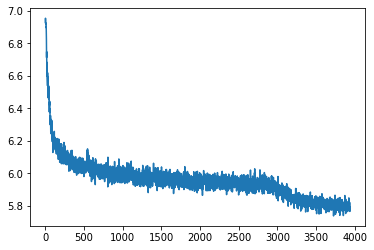

In [466]:
plt.figure()
plt.plot(losses_train)

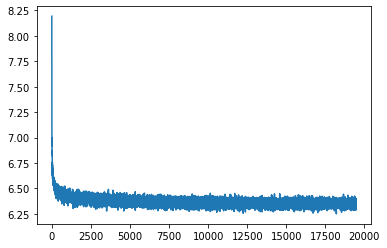

In [88]:
plt.figure()
plt.plot(losses_train)

In [45]:
plt.figure()
plt.plot(losses_train)

In [41]:
classHead

In [109]:
proba = classHead.predict_proba(dataset_train.X)

In [43]:
# classHead.fit(X_train[:, None, :, :], y_train)



proba = classHead.predict_proba(X_train[:, None, :, :])
final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])

dataset_train.set_classweights(final_weights)


In [44]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
logreg = LogisticRegression(solver='liblinear')
head = classHead.get_simCLR_head(X_train[:, None, ...])
# head = classHead.norm_head(head)
# head = head[:, [_ for _ in range(64) if _ not in [7, 15, 20, 21, 36, 54, 57, 60, 61, 62, 63, 64]]]
components , scores , decomposition.explained_variance_ratio_ , stds = decomposition.simple_pca(head, n_components=None)

# logreg.fit(scores[:, :], y_train)
# logreg.predict_proba(scores[:, :])
logreg.fit(head, y_train)
logreg.predict_proba(head)

array([[7.38606327e-13, 9.82938418e-09, 5.31466834e-06, 9.99994676e-01],
       [1.62968581e-01, 2.46029907e-01, 3.00199851e-01, 2.90801661e-01],
       [2.38470334e-11, 9.68791835e-08, 2.48697816e-05, 9.99975033e-01],
       ...,
       [2.35114301e-10, 4.41739816e-07, 7.60582958e-05, 9.99923500e-01],
       [3.22474556e-06, 2.38832089e-04, 6.03245991e-03, 9.93725483e-01],
       [1.19631619e-14, 6.07571093e-10, 5.86688485e-07, 9.99999413e-01]])

<IPython.core.display.Javascript object>


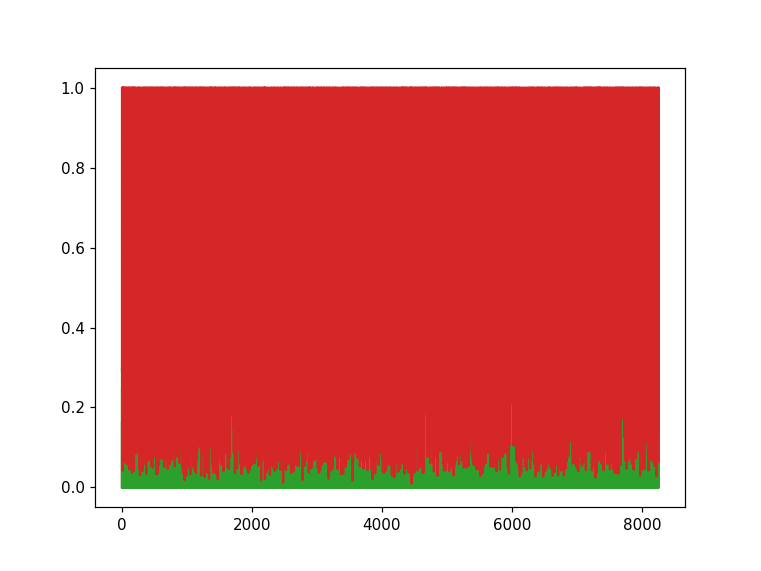

In [46]:
prd = logreg.predict_proba(head)
# prd = logreg.predict_proba(scores[:, :2])
plt.figure()
# plt.plot(logreg.predict_proba(scores[:, :2]))
plt.plot(logreg.predict_proba(head))

In [47]:
# cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(scores[:, :2]), axis=1))
cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(head), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

array([[0.45, 0.39, 0.13, 0.  ],
       [0.31, 0.35, 0.34, 0.01],
       [0.2 , 0.21, 0.34, 0.03],
       [0.03, 0.05, 0.18, 0.96]])

In [159]:
# cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(scores[:, :2]), axis=1))
cm = confusion_matrix(y_train, np.argmax(classHead.predict_proba(X_train), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 1, 5, 5], but got 3-dimensional input of size [8256, 36, 36] instead

In [48]:
logreg.predict_proba(classHead.get_simCLR_head(X_val[:, None, :, :]))

array([[6.24413387e-04, 7.08298809e-03, 4.78895874e-02, 9.44403011e-01],
       [1.46328821e-15, 1.52492185e-10, 2.02354552e-07, 9.99999797e-01],
       [3.05682540e-14, 1.13200002e-09, 9.43359933e-07, 9.99999056e-01],
       ...,
       [9.96917403e-10, 1.15630352e-06, 1.62694854e-04, 9.99836148e-01],
       [1.47265253e-01, 2.32845574e-01, 2.86896827e-01, 3.32992347e-01],
       [2.41787743e-11, 9.68560866e-08, 2.39367315e-05, 9.99975966e-01]])

In [156]:
logreg.

<IPython.core.display.Javascript object>


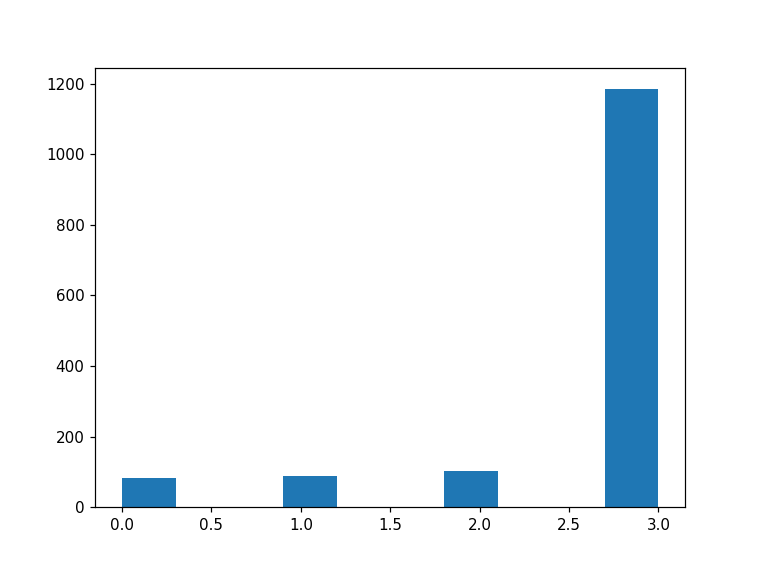

(array([  82.,    0.,    0.,   88.,    0.,    0.,  103.,    0.,    0.,
        1185.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

In [152]:
plt.figure()
plt.hist(y_val)

In [142]:
# cm = confusion_matrix(y_val, np.argmax(logreg.predict_proba(classHead.get_simCLR_head(X_val[:, None, :, :])), axis=1))
cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(classHead.get_simCLR_head(X_train[:, None, :, :])), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

<ipython-input-142-c80fd9395cce>:3: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm/cm.sum(axis=0), 2)


array([[0.18, 0.  ,  nan, 0.  ],
       [0.21, 0.  ,  nan, 0.  ],
       [0.23, 0.  ,  nan, 0.  ],
       [0.37, 1.  ,  nan, 1.  ]])

In [46]:
y_val.shape

(1458,)

In [47]:
y_train.shape

(8256,)

In [49]:
logreg.score((components @ classHead.get_simCLR_head(X_val[:, None, ...]).T).T[:, :2], y_val)

ValueError: X has 2 features per sample; expecting 64

In [ ]:
plt.figure()
plt.plot(y_train)

In [ ]:
head.shape

In [ ]:
plt.figure()
plt.imshow(scores[:, :2], aspect='auto', interpolation='none')

In [ ]:
for colnum in range(64):
    print(head[:, colnum].min(), head[:, colnum].max(), head[:, colnum].mean(), head[:, colnum].std())

In [ ]:
import pandas as pd
with pd.option_context('max_rows', 1000, 'max_columns', 1000):
    display(pd.DataFrame(head).corr())

In [ ]:
classHead.headmodel.predict_proba(head)

In [ ]:
classHead.fit(X_train[:, None, :, :], y_train)

In [ ]:
classHead.predict_proba(X_train[:, None, :, :])

In [ ]:
# df = pd.DataFrame(np.concatenate([classHead.predict(X_val[:, None, :, :]).reshape(-1,1), y_val.reshape(-1,1)], -1))
# confusion_matrix(df[1], df[0])
# df

In [ ]:
idx_sample = 5
classHead.predict_proba(X_train[idx_sample:idx_sample+1, None, ...])

In [ ]:
sample_weight = util.loss_uncertainty(torch.as_tensor(proba), temperature=1, class_value=dataset_train.class_weights)

In [ ]:
sample_weight

In [ ]:
proba.shape

In [ ]:
X_train.shape

In [ ]:
for tmp in range(0,1):
    v = dataset_train.__getitem__(tmp)
#     if abs(v[-1].item() - 0.2) >= 0.001:
#         print(v)
#     print(v)

In [ ]:
dataset_train.__getitem__(0)

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(((np.abs(dataset_train.tmp.numpy() - X_train[0:1, None, ...]) > 0.01 )*255).squeeze())
# plt.imshow(((X_train[0:1, None, ...] != 0)*255).squeeze())

In [ ]:
sample_weight = util.loss_uncertainty(torch.as_tensor(classHead.predict_proba(X_train[:,None,...])), temperature=1, class_value=dataset_train.class_weights)
sample_weight

## Check embeddings

In [305]:
torch.cuda.empty_cache()

In [98]:
# features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
features = model(torch.tensor(images_labeled[labels != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [99]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [101]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=80.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

<IPython.core.display.Javascript object>


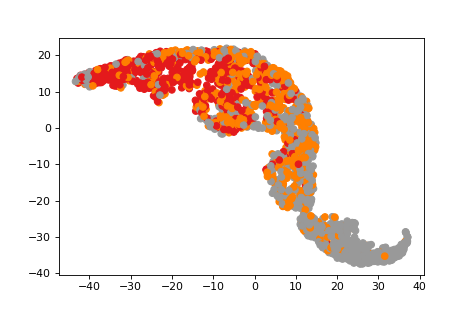

In [102]:
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


## Check filters

In [56]:
list(model.state_dict().keys())

['cnn_layers.0.weight',
 'cnn_layers.0.bias',
 'cnn_layers.2.weight',
 'cnn_layers.2.bias',
 'cnn_layers.5.weight',
 'cnn_layers.5.bias',
 'cnn_layers.8.weight',
 'cnn_layers.8.bias',
 'linear_layers.0.weight',
 'linear_layers.0.bias',
 'linear_layers.2.weight',
 'linear_layers.2.bias']

<IPython.core.display.Javascript object>


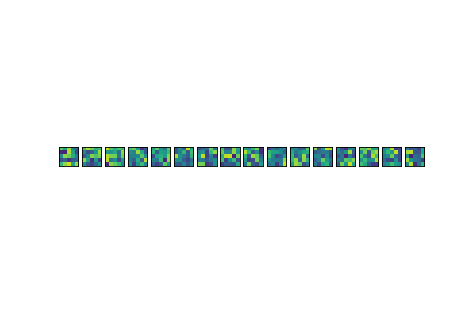

<IPython.core.display.Javascript object>


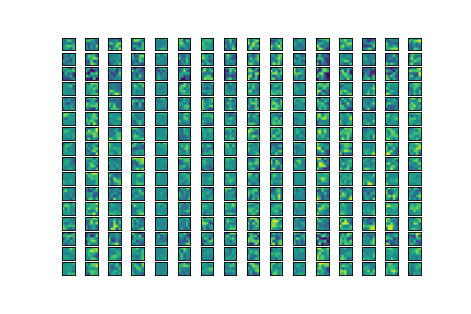

<IPython.core.display.Javascript object>


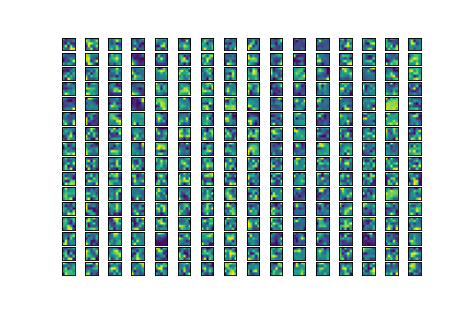

<IPython.core.display.Javascript object>


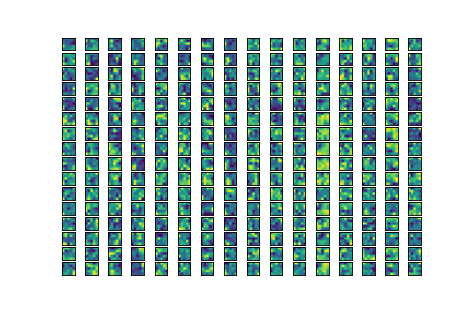

In [351]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()